In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## The Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 21 fields.

In [3]:
data = pd.read_csv('banking.csv', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(26534, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


In [4]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0.0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0.0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1.0
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0.0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1.0


#### Input variables

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric)

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

#### Predict variable (desired target):

y - has the client subscribed a term deposit? (binary: '1','0')

The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

In [5]:
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

Let us group "basic.4y", "basic.9y" and "basic.6y" together and call them "basic".

In [7]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

After grouping, this is the columns.

In [8]:
data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

### Data exploration

In [9]:
data['y'].value_counts()

0.0    23479
1.0     3055
Name: y, dtype: int64

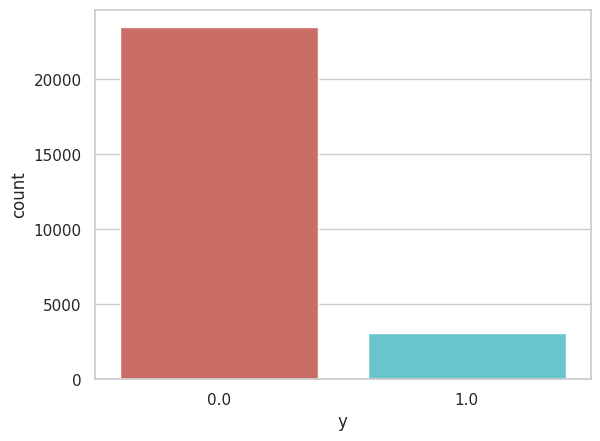

In [10]:
sns.countplot(x='y',data=data, palette='hls')
plt.show()

In [11]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 88.48647018919122
percentage of subscription 11.513529810808773


Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 89:11. Before we go ahead to balance the classes, Let's do some more exploration.

In [12]:
data.groupby('y').mean()

<ipython-input-12-1c0ce2b04705>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('y').mean()


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0.0,39.910899,219.470080,2.635887,984.543890,0.133907,0.251480,93.606358,-40.573044,3.814634,5176.192334
1.0,40.701146,556.452046,2.031097,790.950573,0.487070,-1.213552,93.370053,-39.887496,2.135008,5095.507660


Observations:

The average age of customers who bought the term deposit is higher than that of the customers who didn't. The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale. Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [13]:
data.groupby('job').mean()

<ipython-input-13-91ec6f027066>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('job').mean()


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.102288,254.599970,2.608644,955.500224,0.190070,0.016704,93.537921,-40.280888,3.548575,5163.958576,0.134141
blue-collar,39.451656,263.929575,2.554868,985.552191,0.122449,0.258782,93.663685,-41.370492,3.780809,5175.921646,0.069254
entrepreneur,41.673913,268.369565,2.594203,978.430642,0.138716,0.169462,93.607479,-41.126812,3.813107,5176.360145,0.097308
housemaid,45.519882,254.412371,2.652430,966.823270,0.110457,0.462150,93.687080,-39.591458,4.040230,5181.219293,0.092784
management,42.387181,255.921313,2.512246,958.627931,0.195414,-0.030328,93.525875,-40.490620,3.582950,5165.397134,0.113080
retired,62.127949,279.692377,2.419238,901.634301,0.331216,-0.723049,93.426040,-38.458439,2.748401,5120.965517,0.255898
self-employed,39.934479,262.816327,2.664876,976.586466,0.160043,0.072932,93.546426,-40.478518,3.681635,5170.399785,0.099893
services,37.913113,259.732961,2.601435,979.998007,0.153846,0.216660,93.651030,-41.199083,3.740602,5172.803308,0.086887
student,25.922261,273.491166,2.090106,837.747350,0.531802,-1.430035,93.340569,-40.334276,1.847788,5083.823675,0.328622


In [14]:
data.groupby('marital').mean()

<ipython-input-14-91bb8e81df13>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('marital').mean()


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.789350,252.319178,2.578362,967.867206,0.175261,0.142602,93.602852,-40.773441,3.692073,5169.991304,0.103134
married,42.281954,257.914499,2.581643,967.917735,0.156067,0.188768,93.602131,-40.253304,3.750339,5171.939371,0.103547
single,33.172687,261.211763,2.523029,947.949644,0.213509,-0.166873,93.520881,-40.898738,3.317179,5154.886263,0.144756
unknown,40.240000,286.760000,3.340000,939.580000,0.280000,-0.336000,93.465700,-41.050000,3.217640,5154.556000,0.140000


In [15]:
data.groupby('education').mean()

<ipython-input-15-4c375781e437>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('education').mean()


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.131010,262.219627,2.555803,976.299716,0.141762,0.194661,93.644792,-40.893141,3.736538,5172.081016,0.087134
high.school,37.966776,263.164803,2.576645,964.880592,0.184375,0.049507,93.592977,-40.895576,3.571425,5165.295493,0.112664
illiterate,47.083333,247.583333,2.416667,999.000000,0.083333,0.225000,93.433583,-42.450000,3.839083,5187.775000,0.166667
professional.course,40.057278,255.692058,2.596988,959.743136,0.160319,0.179097,93.571147,-40.143608,3.714380,5170.538028,0.118984
university.degree,38.895226,250.772120,2.555824,950.056015,0.198218,-0.043806,93.492923,-39.988224,3.510297,5162.305716,0.140038
unknown,43.218215,263.681695,2.567178,939.059513,0.237151,0.050406,93.661212,-40.014427,3.552376,5159.165555,0.144274


Visualizations

Text(0, 0.5, 'Frequency of Purchase')

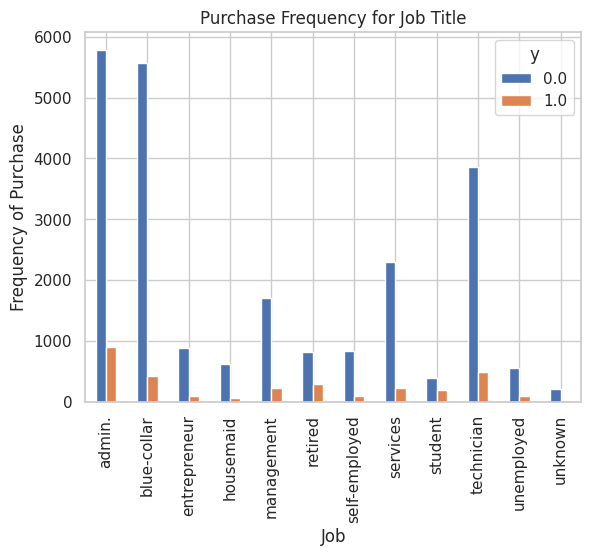

In [16]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

Text(0, 0.5, 'Proportion of Customers')

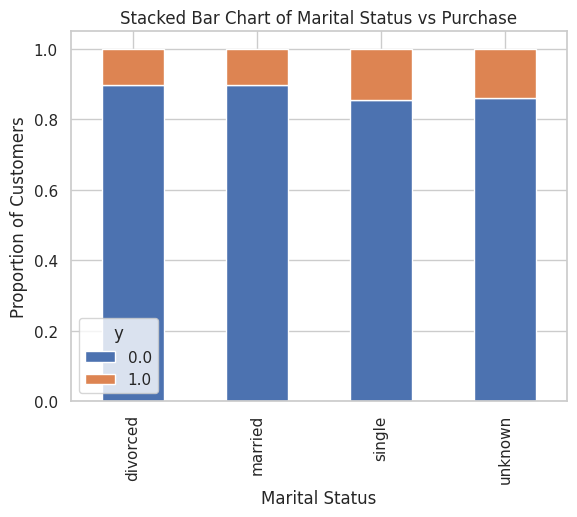

In [17]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')

Hard to see, but the marital status does not seem a strong predictor for the outcome variable.

Text(0, 0.5, 'Proportion of Customers')

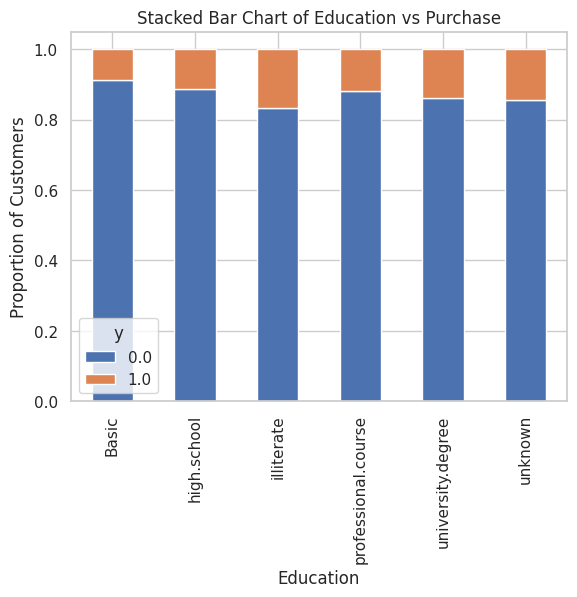

In [18]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')

Education seems a good predictor of the outcome variable.

Text(0, 0.5, 'Frequency of Purchase')

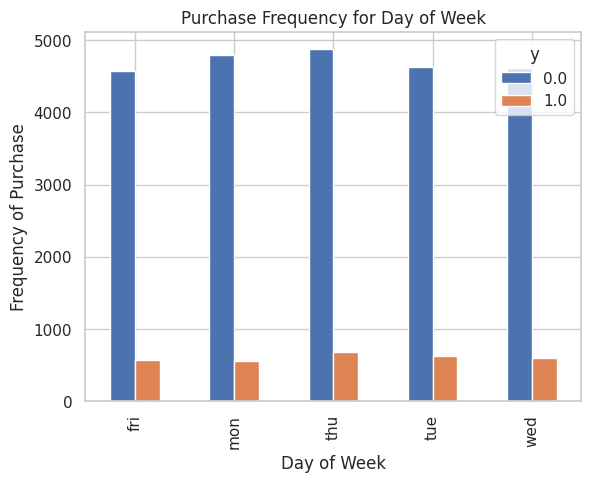

In [19]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')

Day of week may not be a good predictor of the outcome.

Text(0, 0.5, 'Frequency of Purchase')

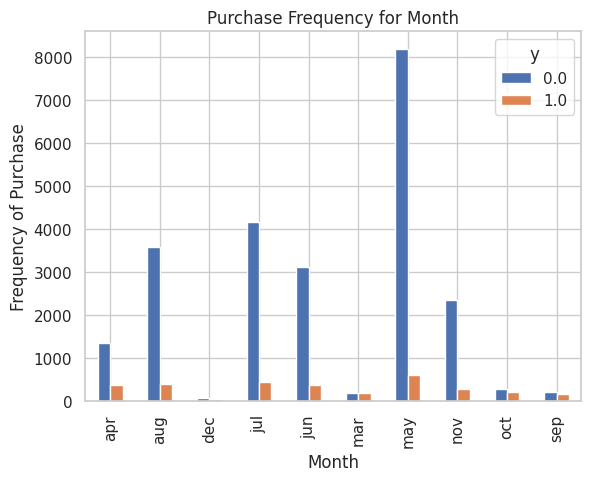

In [20]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')

Month might be a good predictor of the outcome variable.

Text(0, 0.5, 'Frequency')

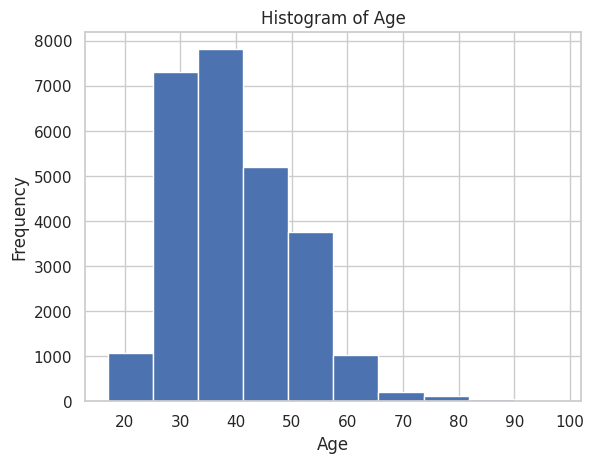

In [21]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

Most customers of the bank in this dataset are in the age range of 30-40.

Text(0, 0.5, 'Frequency of Purchase')

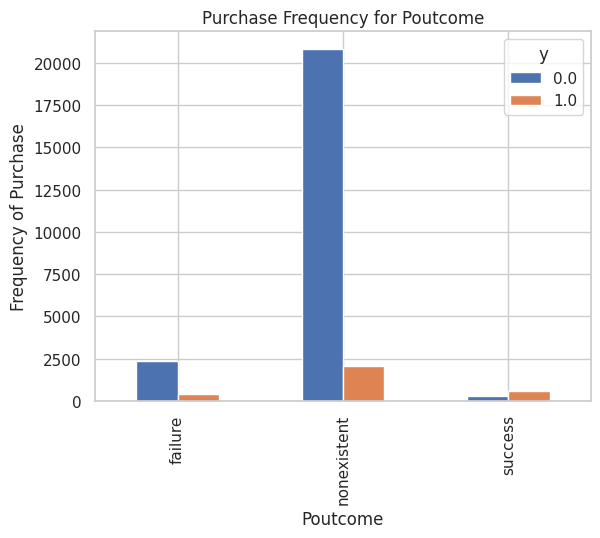

In [22]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')

Poutcome seems to be a good predictor of the outcome variable.

### Create dummy variables

In [23]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1

cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=data[to_keep]
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

### Over-sampling using SMOTE

In [28]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']

In [29]:
!pip install SMOTE

In [31]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
os = SMOTE(random_state=50)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  32846
Number of no subscription in oversampled data 16423
Number of subscription 16423
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


### Recursive feature elimination

In [32]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

In [38]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[False False False False False False False False False False False  True
 False  True  True False  True  True False  True False  True  True  True
  True False  True  True False  True  True  True False False False  True
  True  True  True  True  True  True  True False False False False False
 False False False False False  True  True  True  True  True  True  True
 False]
[22 23 19 26 18 12 16 24 17 21  3  1  2  1  1 11  1  1 28  1  4  1  1  1
  1 30  1  1 31  1  1  1 25 14 32  1  1  1  1  1  1  1  1 10  5 29  7  9
 20  8  6 13 27  1  1  1  1  1  1  1 15]


The Recursive Feature Elimination (RFE) has helped us select the following features: "previous", "euribor3m", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", "month_aug", "month_dec", "month_jul", "month_nov", "month_oct", "month_sep", "day_of_week_fri", "day_of_week_wed", "poutcome_failure", "poutcome_nonexistent", "poutcome_success".

In [39]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 'default_no', 'default_unknown',
      'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar',
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"]
X=os_data_X[cols]
y=os_data_y['y']

### Implementing the model

In [40]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.450923
         Iterations 7
                           Results: Logit
Model:                Logit             Method:            MLE       
Dependent Variable:   y                 Pseudo R-squared:  0.349     
Date:                 2023-10-05 04:28  AIC:               29662.0521
No. Observations:     32846             BIC:               29830.0438
Df Model:             19                Log-Likelihood:    -14811.   
Df Residuals:         32826             LL-Null:           -22767.   
Converged:            1.0000            LLR p-value:       0.0000    
No. Iterations:       7.0000            Scale:             1.0000    
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m             0.1575   0.0098  16.0030 0.0000  0.1382  0.1768
job_blue-collar 

The p-values for four variables are very high, therefore, we will remove them.

In [41]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate',
      'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar',
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"]
X=os_data_X[cols]
y=os_data_y['y']

In [42]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.539524
         Iterations 7
                           Results: Logit
Model:                Logit             Method:            MLE       
Dependent Variable:   y                 Pseudo R-squared:  0.222     
Date:                 2023-10-05 04:28  AIC:               35474.4155
No. Observations:     32846             BIC:               35608.8089
Df Model:             15                Log-Likelihood:    -17721.   
Df Residuals:         32830             LL-Null:           -22767.   
Converged:            1.0000            LLR p-value:       0.0000    
No. Iterations:       7.0000            Scale:             1.0000    
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m             0.1958   0.0069  28.3807 0.0000  0.1822  0.2093
job_blue-collar 

### Logistic Regression Model Fitting

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [44]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.84


### Confusion Matrix

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[4285  635]
 [ 958 3976]]


In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84      4920
         1.0       0.86      0.81      0.83      4934

    accuracy                           0.84      9854
   macro avg       0.84      0.84      0.84      9854
weighted avg       0.84      0.84      0.84      9854



#### Interpretation:

Of the entire test set, 74% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 74% of the customer's preferred term deposit were promoted.

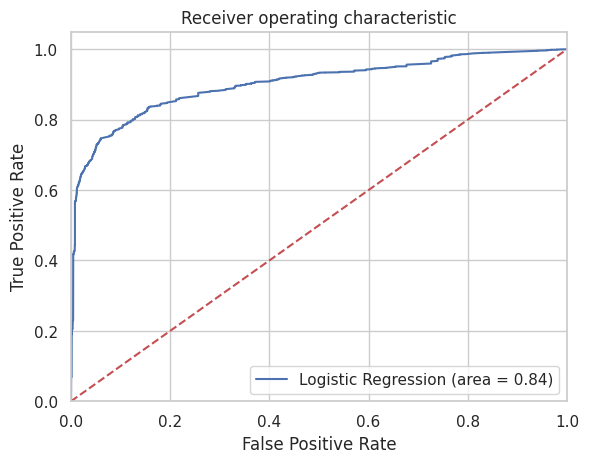

In [47]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [48]:
# 模型存檔
import joblib

joblib.dump(logreg, 'model.custom')


['model.custom']